In [1]:
import os
import math
from abc import abstractmethod

from PIL import Image
import requests
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Gamma
from torchvision import datasets, transforms
from torchvision.utils import save_image
import torch_fidelity
from tqdm import tqdm
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# use sinusoidal position embedding to encode time step (https://arxiv.org/abs/1706.03762)   
def timestep_embedding(timesteps, dim, max_period=10000):
    """
    Create sinusoidal timestep embeddings.
    :param timesteps: a 1-D Tensor of N indices, one per batch element.
                      These may be fractional.
    :param dim: the dimension of the output.
    :param max_period: controls the minimum frequency of the embeddings.
    :return: an [N x dim] Tensor of positional embeddings.
    """
    half = dim // 2
    freqs = torch.exp(
        -math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32) / half
    ).to(device=timesteps.device)
    args = timesteps[:, None].float() * freqs[None]
    embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
    if dim % 2:
        embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
    return embedding

In [3]:
# define TimestepEmbedSequential to support `time_emb` as extra input
class TimestepBlock(nn.Module):
    """
    Any module where forward() takes timestep embeddings as a second argument.
    """

    @abstractmethod
    def forward(self, x, emb):
        """
        Apply the module to `x` given `emb` timestep embeddings.
        """


class TimestepEmbedSequential(nn.Sequential, TimestepBlock):
    """
    A sequential module that passes timestep embeddings to the children that
    support it as an extra input.
    """

    def forward(self, x, emb):
        for layer in self:
            if isinstance(layer, TimestepBlock):
                x = layer(x, emb)
            else:
                x = layer(x)
        return x

# use GN for norm layer
def norm_layer(channels):
    return nn.GroupNorm(32, channels)

In [4]:
# Residual block
class ResidualBlock(TimestepBlock):
    def __init__(self, in_channels, out_channels, time_channels, dropout):
        super().__init__()
        self.conv1 = nn.Sequential(
            norm_layer(in_channels),
            nn.SiLU(),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        )
        
        # pojection for time step embedding
        self.time_emb = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_channels, out_channels)
        )
        
        self.conv2 = nn.Sequential(
            norm_layer(out_channels),
            nn.SiLU(),
            nn.Dropout(p=dropout),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        )

        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        else:
            self.shortcut = nn.Identity()


    def forward(self, x, t):
        """
        `x` has shape `[batch_size, in_dim, height, width]`
        `t` has shape `[batch_size, time_dim]`
        """
        h = self.conv1(x)
        # Add time step embeddings
        h += self.time_emb(t)[:, :, None, None]
        h = self.conv2(h)
        return h + self.shortcut(x)

In [5]:
# Attention block with shortcut
class AttentionBlock(nn.Module):
    def __init__(self, channels, num_heads=1):
        super().__init__()
        self.num_heads = num_heads
        assert channels % num_heads == 0
        
        self.norm = norm_layer(channels)
        self.qkv = nn.Conv2d(channels, channels * 3, kernel_size=1, bias=False)
        self.proj = nn.Conv2d(channels, channels, kernel_size=1)

    def forward(self, x):
        B, C, H, W = x.shape
        qkv = self.qkv(self.norm(x))
        q, k, v = qkv.reshape(B*self.num_heads, -1, H*W).chunk(3, dim=1)
        scale = 1. / math.sqrt(math.sqrt(C // self.num_heads))
        attn = torch.einsum("bct,bcs->bts", q * scale, k * scale)
        attn = attn.softmax(dim=-1)
        h = torch.einsum("bts,bcs->bct", attn, v)
        h = h.reshape(B, -1, H, W)
        h = self.proj(h)
        return h + x

In [6]:
# upsample
class Upsample(nn.Module):
    def __init__(self, channels, use_conv):
        super().__init__()
        self.use_conv = use_conv
        if use_conv:
            self.conv = nn.Conv2d(channels, channels, kernel_size=3, padding=1)

    def forward(self, x):
        x = F.interpolate(x, scale_factor=2, mode="nearest")
        if self.use_conv:
            x = self.conv(x)
        return x

# downsample
class Downsample(nn.Module):
    def __init__(self, channels, use_conv):
        super().__init__()
        self.use_conv = use_conv
        if use_conv:
            self.op = nn.Conv2d(channels, channels, kernel_size=3, stride=2, padding=1)
        else:
            self.op = nn.AvgPool2d(stride=2)

    def forward(self, x):
        return self.op(x)

In [7]:
# The full UNet model with attention and timestep embedding
class UNetModel(nn.Module):
    def __init__(
        self,
        in_channels=3,
        model_channels=128,
        out_channels=3,
        num_res_blocks=2,
        attention_resolutions=(8, 16),
        dropout=0,
        channel_mult=(1, 2, 2, 2),
        conv_resample=True,
        num_heads=4
    ):
        super().__init__()

        self.in_channels = in_channels
        self.model_channels = model_channels
        self.out_channels = out_channels
        self.num_res_blocks = num_res_blocks
        self.attention_resolutions = attention_resolutions
        self.dropout = dropout
        self.channel_mult = channel_mult
        self.conv_resample = conv_resample
        self.num_heads = num_heads
        
        # time embedding
        time_embed_dim = model_channels * 4
        self.time_embed = nn.Sequential(
            nn.Linear(model_channels, time_embed_dim),
            nn.SiLU(),
            nn.Linear(time_embed_dim, time_embed_dim),
        )
        
        # down blocks
        self.down_blocks = nn.ModuleList([
            TimestepEmbedSequential(nn.Conv2d(in_channels, model_channels, kernel_size=3, padding=1))
        ])
        down_block_chans = [model_channels]
        ch = model_channels
        ds = 1
        for level, mult in enumerate(channel_mult):
            for _ in range(num_res_blocks):
                layers = [
                    ResidualBlock(ch, mult * model_channels, time_embed_dim, dropout)
                ]
                ch = mult * model_channels
                if ds in attention_resolutions:
                    layers.append(AttentionBlock(ch, num_heads=num_heads))
                self.down_blocks.append(TimestepEmbedSequential(*layers))
                down_block_chans.append(ch)
            if level != len(channel_mult) - 1: # don't use downsample for the last stage
                self.down_blocks.append(TimestepEmbedSequential(Downsample(ch, conv_resample)))
                down_block_chans.append(ch)
                ds *= 2
        
        # middle block
        self.middle_block = TimestepEmbedSequential(
            ResidualBlock(ch, ch, time_embed_dim, dropout),
            AttentionBlock(ch, num_heads=num_heads),
            ResidualBlock(ch, ch, time_embed_dim, dropout)
        )
        
        # up blocks
        self.up_blocks = nn.ModuleList([])
        for level, mult in list(enumerate(channel_mult))[::-1]:
            for i in range(num_res_blocks + 1):
                layers = [
                    ResidualBlock(
                        ch + down_block_chans.pop(),
                        model_channels * mult,
                        time_embed_dim,
                        dropout
                    )
                ]
                ch = model_channels * mult
                if ds in attention_resolutions:
                    layers.append(AttentionBlock(ch, num_heads=num_heads))
                if level and i == num_res_blocks:
                    layers.append(Upsample(ch, conv_resample))
                    ds //= 2
                self.up_blocks.append(TimestepEmbedSequential(*layers))

        self.out = nn.Sequential(
            norm_layer(ch),
            nn.SiLU(),
            nn.Conv2d(model_channels, out_channels, kernel_size=3, padding=1),
        )

    def forward(self, x, timesteps):
        """
        Apply the model to an input batch.
        :param x: an [N x C x H x W] Tensor of inputs.
        :param timesteps: a 1-D batch of timesteps.
        :return: an [N x C x ...] Tensor of outputs.
        """
        hs = []
        # time step embedding
        emb = self.time_embed(timestep_embedding(timesteps, self.model_channels))
        
        # down stage
        h = x
        for module in self.down_blocks:
            h = module(h, emb)
            hs.append(h)
        # middle stage
        h = self.middle_block(h, emb)
        # up stage
        for module in self.up_blocks:
            cat_in = torch.cat([h, hs.pop()], dim=1)
            h = module(cat_in, emb)
        return self.out(h)

In [8]:
# beta schedule
def linear_beta_schedule(timesteps):
    scale = 1000 / timesteps
    beta_start = scale * 0.0001
    beta_end = scale * 0.02
    return torch.linspace(beta_start, beta_end, timesteps, dtype=torch.float64)

def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule
    as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps, dtype=torch.float64)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * math.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0, 0.999)

def sigmoid_beta_schedule(timesteps, start = -3, end = 3, tau = 1, clamp_min = 1e-5):
    """
    sigmoid schedule
    proposed in https://arxiv.org/abs/2212.11972 - Figure 8
    better for images > 64x64, when used during training
    """
    steps = timesteps + 1
    t = torch.linspace(0, timesteps, steps, dtype = torch.float64) / timesteps
    v_start = torch.tensor(start / tau).sigmoid()
    v_end = torch.tensor(end / tau).sigmoid()
    alphas_cumprod = (-((t * (end - start) + start) / tau).sigmoid() + v_end) / (v_end - v_start)
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0, 0.999)

def sqrt_beta_schedule(timesteps, s=0.0001):
    """
    sigmoid schedule
    proposed in https://arxiv.org/abs/2205.14217
    """
    steps = timesteps + 1
    t = torch.linspace(0, timesteps, steps, dtype = torch.float64) / timesteps
    alphas_cumprod = 1 - torch.sqrt(t + s)
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0, 0.999)

In [9]:
class GaussianDiffusion:
    def __init__(
        self,
        timesteps=1000,
        theta_0=0.001,
        beta_schedule='linear'
    ):
        self.timesteps = timesteps
        
        if beta_schedule == 'linear':
            betas = linear_beta_schedule(timesteps)
        elif beta_schedule == 'cosine':
            betas = cosine_beta_schedule(timesteps)
        elif beta_schedule == 'sigmoid':
            betas = sigmoid_beta_schedule(timesteps)
        elif beta_schedule == 'sqrt':
            betas = sqrt_beta_schedule(timesteps)
        else:
            raise ValueError(f'unknown beta schedule {beta_schedule}')
        self.betas = betas
        self.alphas = 1. - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1, 0), value=1.)
        
        # calculations for diffusion q(x_t | x_{t-1}) and others
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alphas_cumprod)
        self.log_one_minus_alphas_cumprod = torch.log(1.0 - self.alphas_cumprod)
        self.sqrt_recip_alphas_cumprod = torch.sqrt(1.0 / self.alphas_cumprod)
        self.sqrt_recipm1_alphas_cumprod = torch.sqrt(1.0 / self.alphas_cumprod - 1)
        
        # gamma atribute
        self.theta_0 = theta_0 
        self.kappas = (self.betas / self.alphas_cumprod / self.theta_0**2)
        self.thetas = (self.theta_0 * self.sqrt_alphas_cumprod)
        self.kappas_cumsum = torch.cumsum(self.kappas, axis=0)
        self.kappas_cumsum_thetas =  (self.kappas_cumsum * self.thetas)
        self.log_betas = torch.log(self.betas)
        self.kappas_cumsum_thetas_over_sqrt_alphas_cumprod = (self.sqrt_recip_alphas_cumprod * self.kappas_cumsum_thetas)
        
        # calculations for posterior q(x_{t-1} | x_t, x_0)
        self.posterior_variance = (
            #self.betas * (1.0 - self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
            self.betas
        )
        # below: log calculation clipped because the posterior variance is 0 at the beginning
        # of the diffusion chain
        self.posterior_log_variance_clipped = torch.log(self.posterior_variance.clamp(min =1e-20))
        
        self.posterior_mean_coef1 = (
            self.betas * torch.sqrt(self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        )
        self.posterior_mean_coef2 = (
            (1.0 - self.alphas_cumprod_prev)
            * torch.sqrt(self.alphas)
            / (1.0 - self.alphas_cumprod)
        )
    
    # get the param of given timestep t
    def _extract(self, a, t, x_shape):
        batch_size = t.shape[0]
        out = a.to(t.device).gather(0, t).float()
        out = out.reshape(batch_size, *((1,) * (len(x_shape) - 1)))
        return out
    
    # forward diffusion (using the nice property): q(x_t | x_0)
    def q_sample(self, x_start, t, noise=None):
        if noise is None:
            #noise = torch.randn_like(x_start)
            kappas_cumsum_t = self._extract(self.kappas_cumsum, t , x_start.shape)
            thetas_t = self._extract(self.thetas, t , x_start.shape)
            noise = Gamma(kappas_cumsum_t.squeeze(), (1/thetas_t).squeeze()).sample(x_start.shape)
            
        kappas_cumsum_thetas_t = self._extract(self.kappas_cumsum_thetas, t, x_start.shape)
        sqrt_alphas_cumprod_t = self._extract(self.sqrt_alphas_cumprod, t, x_start.shape)
        #sqrt_one_minus_alphas_cumprod_t = self._extract(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape)
    
        return sqrt_alphas_cumprod_t * x_start + noise - kappas_cumsum_thetas_t
        #return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise
        
    # Get the mean and variance of q(x_t | x_0).
    def q_mean_variance(self, x_start, t):
        mean = self._extract(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start
        variance = self._extract(1.0 - self.alphas_cumprod, t, x_start.shape)
        #variance = self._extract(self.betas, t, x_start.shape)
        log_variance = self._extract(self.log_one_minus_alphas_cumprod, t, x_start.shape)
        #log_variance = self._extract(self.log_betas, t, x_start.shape)
        return mean, variance, log_variance
    
    # Compute the mean and variance of the diffusion posterior: q(x_{t-1} | x_t, x_0)
    def q_posterior_mean_variance(self, x_start, x_t, t):
        posterior_mean = (
            self._extract(self.posterior_mean_coef1, t, x_t.shape) * x_start
            + self._extract(self.posterior_mean_coef2, t, x_t.shape) * x_t
        )
        posterior_variance = self._extract(self.posterior_variance, t, x_t.shape)
        posterior_log_variance_clipped = self._extract(self.posterior_log_variance_clipped, t, x_t.shape)
        
        return posterior_mean, posterior_variance, posterior_log_variance_clipped
    
    # compute x_0 from x_t and pred noise: the reverse of `q_sample`
    def predict_start_from_noise(self, x_t, t, noise):
        return (
            self._extract(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t -
            self._extract(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape) * noise
        )
    
    # compute predicted mean and variance of p(x_{t-1} | x_t)
    def p_mean_variance(self, model, x_t, t, clip_denoised=True):
        # predict noise using model
        pred_noise = model(x_t, t)
        # get the predicted x_0: different from the algorithm2 in the paper
        x_recon = self.predict_start_from_noise(x_t, t, pred_noise)
        if clip_denoised:
            x_recon = torch.clamp(x_recon, min=-1., max=1.)
        model_mean, posterior_variance, posterior_log_variance = \
                    self.q_posterior_mean_variance(x_recon, x_t, t)
        return model_mean, posterior_variance, posterior_log_variance
        
    # denoise_step: sample x_{t-1} from x_t and pred_noise
    @torch.no_grad()
    def p_sample(self, model, x_t, t, clip_denoised=True):
        # predict mean and variance
        model_mean, _, model_log_variance = self.p_mean_variance(model, x_t, t,
                                                    clip_denoised=clip_denoised)
        #noise = torch.randn_like(x_t)
        #gamma noise
        kappas_cumsum_tm1 = self._extract(self.kappas_cumsum, t, x_t.shape)
        thetas_tm1 = self._extract(self.thetas, t, x_t.shape)
        kappas_cumsum_thetas_tm1 = self._extract(self.kappas_cumsum_thetas, t, x_t.shape)
        sqrt_one_minus_alphas_cumprod_t = self._extract(self.sqrt_one_minus_alphas_cumprod, t, x_t.shape)
        gamma_tm1 = Gamma(kappas_cumsum_tm1.squeeze(), (1/thetas_tm1.squeeze())).sample(x_t.shape[1:])
        gamma_tm1 = gamma_tm1.reshape([-1, x_t.shape[0]]).T
        gamma_tm1 = gamma_tm1.reshape(x_t.shape)
        noise = (gamma_tm1 - kappas_cumsum_thetas_tm1) / sqrt_one_minus_alphas_cumprod_t
        
        # no noise when t == 0
        nonzero_mask = ((t != 0).float().view(-1, *([1] * (len(x_t.shape) - 1))))
        # compute x_{t-1}
        pred_img = model_mean + nonzero_mask * (0.5 * model_log_variance).exp() * noise
        return pred_img
    
    # denoise: reverse diffusion
    @torch.no_grad()
    def p_sample_loop(self, model, shape):
        batch_size = shape[0]
        device = next(model.parameters()).device
        # start from pure noise (for each example in the batch)
        #img = torch.randn(shape, device=device)
        kappas_sumsum_T = self.kappas_cumsum[-1]
        thetas_T = self.thetas[-1]
        img = Gamma(kappas_sumsum_T, (1/thetas_T)).sample(shape).float() - kappas_sumsum_T * thetas_T
        img = img.to(device)
        #img = img.reshape([-1, shape[0]]).T
        #img = img.reshape(shape) - self.kappas_cumsum[-1] * self.thetas[-1]
        imgs = []
        for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
            img = self.p_sample(model, img, torch.full((batch_size,), i, device=device, dtype=torch.long))
            imgs.append(img.cpu().numpy())
        return imgs
    
    # sample new images
    @torch.no_grad()
    def sample(self, model, image_size, batch_size=8, channels=3):
        return self.p_sample_loop(model, shape=(batch_size, channels, image_size, image_size))
    
    # compute train losses
    def train_losses(self, model, x_start, t):
        # generate random noise
        #noise = torch.randn_like(x_start)
        sqrt_one_minus_alphas_cumprod_t = self._extract(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape)
        kappas_cumsum_t = self._extract(self.kappas_cumsum, t, x_start.shape)
        thetas_t = self._extract(self.thetas, t, x_start.shape)
        noise = Gamma(kappas_cumsum_t.squeeze(), (1/thetas_t).squeeze()).sample(x_start.shape[1:])
        noise = noise.reshape([-1, x_start.shape[0]]).T
        noise = noise.reshape(x_start.shape)
        
        # get x_t
        x_noisy = self.q_sample(x_start, t, noise=noise)
        predicted_noise = model(x_noisy, t)
        gamma_noise = (noise -  kappas_cumsum_t * thetas_t) / sqrt_one_minus_alphas_cumprod_t
        loss = F.mse_loss(gamma_noise, predicted_noise)
        return loss

In [11]:
batch_size = 128
timesteps = 1000
beta_schedule = "linear"

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

dataset = datasets.CIFAR10('/data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = UNetModel(
    in_channels=3,
    model_channels=128,
    out_channels=3,
    channel_mult=(1, 2, 2, 2),
    attention_resolutions=(2,),
    dropout=0.1
)

gaussian_diffusion = GaussianDiffusion(timesteps=timesteps, theta_0=0.001, beta_schedule=beta_schedule)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)

Files already downloaded and verified


In [11]:
epochs = 200

RESUME = False
checkpoint_file = r"E:\model\checkpoint.pth"
start_epoch = -1

if RESUME:
    check_point = torch.load(checkpoint_file)
    model.load_state_dict(check_point["model_state_dict"])
    optimizer.load_state_dict(check_point["optimizer_state_dict"])
    start_epoch = check_point["epoch"]

In [12]:
#Unet training for gamma noise
for epoch in range(start_epoch+1, epochs):
    total_loss = 0
    for step, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        
        batch_size = images.shape[0]
        images = images.to(device)
        
        # sample t uniformally for every example in the batch
        t = torch.randint(0, timesteps, (batch_size,), device=device).long()
        
        loss = gaussian_diffusion.train_losses(model, images, t)
        total_loss += loss.item()

        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss {total_loss/len(train_loader)}")

        check_point = {
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
        }
        torch.save(check_point, checkpoint_file)

Epoch 0, Loss 0.05448643703137517
Epoch 10, Loss 0.024725349477070675
Epoch 20, Loss 0.02419216459726586
Epoch 30, Loss 0.023778101853321274
Epoch 40, Loss 0.023533535106560154
Epoch 50, Loss 0.02334740353972101
Epoch 60, Loss 0.023343836126463187
Epoch 70, Loss 0.02322491081169499
Epoch 80, Loss 0.023042285619565592
Epoch 90, Loss 0.023135843560518815
Epoch 100, Loss 0.022984091178192508
Epoch 110, Loss 0.022984520263036195
Epoch 120, Loss 0.02297535743993109
Epoch 130, Loss 0.02286653821368504
Epoch 140, Loss 0.022936040135410132
Epoch 150, Loss 0.02284685119300547
Epoch 160, Loss 0.022592701427543254
Epoch 170, Loss 0.022577324167579946
Epoch 180, Loss 0.02245685671601454
Epoch 190, Loss 0.022578311569588567


In [13]:
#save trained Unet model
model_path = fr"E:\model\Gamma_noise_CIFAR_linear.pth"
torch.save(model.state_dict(), model_path)

In [14]:
generated_images = gaussian_diffusion.sample(model, 32, batch_size=64, channels=3)

sampling loop time step: 100%|█████████████████████████████████████████████████████| 1000/1000 [01:32<00:00, 10.78it/s]


In [55]:
#load trained model

model = UNetModel(
    in_channels=3,
    model_channels=128,
    out_channels=3,
    channel_mult=(1, 2, 2, 2),
    attention_resolutions=(2,),
    dropout=0.1
)
model.to(device)
model.load_state_dict(torch.load(model_path))


<All keys matched successfully>

In [17]:
#generate specified numbers of images
n = 1
while n <= 10000:
    generated_images = gaussian_diffusion.sample(model, 32, batch_size=64, channels=3)
    for i in range(64):
        if n <= 10000:
            img = transforms.ToTensor()((generated_images[-1][i].transpose([1,2,0]) + 1) / 2)
            save_image(img, rf"E:\data\CIFAR_{beta_schedule}\{beta_schedule}_{n}.png")
            n += 1
        if n % 1000 == 0:
            print(f"已生成{n}个图像")

sampling loop time step: 100%|█| 1000/1000 [02:01<00:00,  8.21it/s
sampling loop time step: 100%|█| 1000/1000 [01:48<00:00,  9.19it/s
sampling loop time step: 100%|█| 1000/1000 [01:46<00:00,  9.39it/s
sampling loop time step: 100%|█| 1000/1000 [01:47<00:00,  9.31it/s
sampling loop time step: 100%|█| 1000/1000 [01:38<00:00, 10.10it/s
sampling loop time step: 100%|█| 1000/1000 [01:43<00:00,  9.62it/s
sampling loop time step: 100%|█| 1000/1000 [01:47<00:00,  9.33it/s
sampling loop time step: 100%|█| 1000/1000 [01:55<00:00,  8.69it/s
sampling loop time step: 100%|█| 1000/1000 [01:44<00:00,  9.54it/s
sampling loop time step: 100%|█| 1000/1000 [01:51<00:00,  8.97it/s
sampling loop time step: 100%|█| 1000/1000 [01:48<00:00,  9.18it/s
sampling loop time step: 100%|█| 1000/1000 [01:48<00:00,  9.21it/s
sampling loop time step: 100%|█| 1000/1000 [01:47<00:00,  9.34it/s
sampling loop time step: 100%|█| 1000/1000 [01:54<00:00,  8.70it/s
sampling loop time step: 100%|█| 1000/1000 [01:52<00:00,  8.86

已生成1000个图像


sampling loop time step: 100%|█| 1000/1000 [01:42<00:00,  9.76it/s
sampling loop time step: 100%|█| 1000/1000 [01:44<00:00,  9.56it/s
sampling loop time step: 100%|█| 1000/1000 [01:43<00:00,  9.70it/s
sampling loop time step: 100%|█| 1000/1000 [01:37<00:00, 10.25it/s
sampling loop time step: 100%|█| 1000/1000 [01:37<00:00, 10.27it/s
sampling loop time step: 100%|█| 1000/1000 [01:37<00:00, 10.24it/s
sampling loop time step: 100%|█| 1000/1000 [01:37<00:00, 10.28it/s
sampling loop time step: 100%|█| 1000/1000 [01:37<00:00, 10.24it/s
sampling loop time step: 100%|█| 1000/1000 [01:37<00:00, 10.28it/s
sampling loop time step: 100%|█| 1000/1000 [01:37<00:00, 10.22it/s
sampling loop time step: 100%|█| 1000/1000 [01:37<00:00, 10.28it/s
sampling loop time step: 100%|█| 1000/1000 [01:40<00:00,  9.93it/s
sampling loop time step: 100%|█| 1000/1000 [01:39<00:00, 10.04it/s
sampling loop time step: 100%|█| 1000/1000 [01:41<00:00,  9.85it/s
sampling loop time step: 100%|█| 1000/1000 [01:38<00:00, 10.12

已生成2000个图像


sampling loop time step: 100%|█| 1000/1000 [01:40<00:00,  9.95it/s
sampling loop time step: 100%|█| 1000/1000 [01:41<00:00,  9.89it/s
sampling loop time step: 100%|█| 1000/1000 [01:39<00:00, 10.02it/s
sampling loop time step: 100%|█| 1000/1000 [01:40<00:00,  9.93it/s
sampling loop time step: 100%|█| 1000/1000 [01:39<00:00, 10.08it/s
sampling loop time step: 100%|█| 1000/1000 [01:40<00:00,  9.94it/s
sampling loop time step: 100%|█| 1000/1000 [01:40<00:00,  9.97it/s
sampling loop time step: 100%|█| 1000/1000 [01:39<00:00, 10.02it/s
sampling loop time step: 100%|█| 1000/1000 [01:40<00:00,  9.95it/s
sampling loop time step: 100%|█| 1000/1000 [01:39<00:00, 10.04it/s
sampling loop time step: 100%|█| 1000/1000 [01:39<00:00, 10.04it/s
sampling loop time step: 100%|█| 1000/1000 [01:39<00:00, 10.02it/s
sampling loop time step: 100%|█| 1000/1000 [01:40<00:00,  9.93it/s
sampling loop time step: 100%|█| 1000/1000 [01:40<00:00,  9.95it/s
sampling loop time step: 100%|█| 1000/1000 [01:40<00:00,  9.95

已生成3000个图像


sampling loop time step: 100%|█| 1000/1000 [01:37<00:00, 10.28it/s
sampling loop time step: 100%|█| 1000/1000 [01:36<00:00, 10.38it/s
sampling loop time step: 100%|█| 1000/1000 [01:36<00:00, 10.35it/s
sampling loop time step: 100%|█| 1000/1000 [01:36<00:00, 10.37it/s
sampling loop time step: 100%|█| 1000/1000 [01:37<00:00, 10.29it/s
sampling loop time step: 100%|█| 1000/1000 [01:45<00:00,  9.45it/s
sampling loop time step: 100%|█| 1000/1000 [01:40<00:00,  9.98it/s
sampling loop time step: 100%|█| 1000/1000 [01:35<00:00, 10.45it/s
sampling loop time step: 100%|█| 1000/1000 [01:41<00:00,  9.86it/s
sampling loop time step: 100%|█| 1000/1000 [01:35<00:00, 10.42it/s
sampling loop time step: 100%|█| 1000/1000 [01:34<00:00, 10.56it/s
sampling loop time step: 100%|█| 1000/1000 [01:34<00:00, 10.62it/s
sampling loop time step: 100%|█| 1000/1000 [01:34<00:00, 10.57it/s
sampling loop time step: 100%|█| 1000/1000 [01:34<00:00, 10.62it/s
sampling loop time step: 100%|█| 1000/1000 [01:34<00:00, 10.58

已生成4000个图像


sampling loop time step: 100%|█| 1000/1000 [01:34<00:00, 10.58it/s
sampling loop time step: 100%|█| 1000/1000 [01:34<00:00, 10.63it/s
sampling loop time step: 100%|█| 1000/1000 [01:34<00:00, 10.58it/s
sampling loop time step: 100%|█| 1000/1000 [01:34<00:00, 10.61it/s
sampling loop time step: 100%|█| 1000/1000 [01:34<00:00, 10.56it/s
sampling loop time step: 100%|█| 1000/1000 [01:34<00:00, 10.62it/s
sampling loop time step: 100%|█| 1000/1000 [01:34<00:00, 10.58it/s
sampling loop time step: 100%|█| 1000/1000 [01:34<00:00, 10.62it/s
sampling loop time step: 100%|█| 1000/1000 [01:34<00:00, 10.58it/s
sampling loop time step: 100%|█| 1000/1000 [01:34<00:00, 10.63it/s
sampling loop time step: 100%|█| 1000/1000 [01:34<00:00, 10.57it/s
sampling loop time step: 100%|█| 1000/1000 [01:35<00:00, 10.46it/s
sampling loop time step: 100%|█| 1000/1000 [01:37<00:00, 10.25it/s
sampling loop time step: 100%|█| 1000/1000 [01:36<00:00, 10.35it/s
sampling loop time step: 100%|█| 1000/1000 [01:37<00:00, 10.26

已生成5000个图像


sampling loop time step: 100%|█| 1000/1000 [01:37<00:00, 10.26it/s
sampling loop time step: 100%|█| 1000/1000 [01:38<00:00, 10.18it/s
sampling loop time step: 100%|█| 1000/1000 [01:48<00:00,  9.23it/s
sampling loop time step: 100%|█| 1000/1000 [01:45<00:00,  9.51it/s
sampling loop time step: 100%|█| 1000/1000 [01:49<00:00,  9.14it/s
sampling loop time step: 100%|█| 1000/1000 [01:37<00:00, 10.26it/s
sampling loop time step: 100%|█| 1000/1000 [01:47<00:00,  9.34it/s
sampling loop time step: 100%|█| 1000/1000 [01:38<00:00, 10.13it/s
sampling loop time step: 100%|█| 1000/1000 [01:39<00:00, 10.09it/s
sampling loop time step: 100%|█| 1000/1000 [01:44<00:00,  9.60it/s
sampling loop time step: 100%|█| 1000/1000 [01:44<00:00,  9.57it/s
sampling loop time step: 100%|█| 1000/1000 [01:39<00:00, 10.06it/s
sampling loop time step: 100%|█| 1000/1000 [01:38<00:00, 10.16it/s
sampling loop time step: 100%|█| 1000/1000 [01:37<00:00, 10.29it/s
sampling loop time step: 100%|█| 1000/1000 [01:37<00:00, 10.28

已生成6000个图像


sampling loop time step: 100%|█| 1000/1000 [01:36<00:00, 10.36it/s
sampling loop time step: 100%|█| 1000/1000 [01:36<00:00, 10.37it/s
sampling loop time step: 100%|█| 1000/1000 [01:36<00:00, 10.36it/s
sampling loop time step: 100%|█| 1000/1000 [01:39<00:00, 10.07it/s
sampling loop time step: 100%|█| 1000/1000 [01:37<00:00, 10.30it/s
sampling loop time step: 100%|█| 1000/1000 [01:38<00:00, 10.14it/s
sampling loop time step: 100%|█| 1000/1000 [01:43<00:00,  9.63it/s
sampling loop time step: 100%|█| 1000/1000 [01:41<00:00,  9.81it/s
sampling loop time step: 100%|█| 1000/1000 [01:40<00:00,  9.96it/s
sampling loop time step: 100%|█| 1000/1000 [02:05<00:00,  8.00it/s
sampling loop time step: 100%|█| 1000/1000 [01:53<00:00,  8.84it/s
sampling loop time step: 100%|█| 1000/1000 [01:57<00:00,  8.49it/s
sampling loop time step: 100%|█| 1000/1000 [02:14<00:00,  7.46it/s
sampling loop time step: 100%|█| 1000/1000 [01:39<00:00, 10.07it/s
sampling loop time step: 100%|█| 1000/1000 [01:37<00:00, 10.24

已生成7000个图像


sampling loop time step: 100%|█| 1000/1000 [01:46<00:00,  9.38it/s
sampling loop time step: 100%|█| 1000/1000 [01:39<00:00, 10.00it/s
sampling loop time step: 100%|█| 1000/1000 [01:42<00:00,  9.71it/s
sampling loop time step: 100%|█| 1000/1000 [01:46<00:00,  9.43it/s
sampling loop time step: 100%|█| 1000/1000 [01:47<00:00,  9.31it/s
sampling loop time step: 100%|█| 1000/1000 [01:41<00:00,  9.89it/s
sampling loop time step: 100%|█| 1000/1000 [01:37<00:00, 10.23it/s
sampling loop time step: 100%|█| 1000/1000 [01:52<00:00,  8.89it/s
sampling loop time step: 100%|█| 1000/1000 [01:35<00:00, 10.47it/s
sampling loop time step: 100%|█| 1000/1000 [02:02<00:00,  8.14it/s
sampling loop time step: 100%|█| 1000/1000 [01:37<00:00, 10.20it/s
sampling loop time step: 100%|█| 1000/1000 [01:34<00:00, 10.55it/s
sampling loop time step: 100%|█| 1000/1000 [01:33<00:00, 10.65it/s
sampling loop time step: 100%|█| 1000/1000 [01:36<00:00, 10.40it/s
sampling loop time step: 100%|█| 1000/1000 [02:06<00:00,  7.90

已生成8000个图像


sampling loop time step: 100%|█| 1000/1000 [01:49<00:00,  9.12it/s
sampling loop time step: 100%|█| 1000/1000 [01:45<00:00,  9.49it/s
sampling loop time step: 100%|█| 1000/1000 [01:44<00:00,  9.58it/s
sampling loop time step: 100%|█| 1000/1000 [01:39<00:00, 10.09it/s
sampling loop time step: 100%|█| 1000/1000 [01:39<00:00, 10.01it/s
sampling loop time step: 100%|█| 1000/1000 [01:43<00:00,  9.68it/s
sampling loop time step: 100%|█| 1000/1000 [01:42<00:00,  9.77it/s
sampling loop time step: 100%|█| 1000/1000 [01:41<00:00,  9.88it/s
sampling loop time step: 100%|█| 1000/1000 [01:36<00:00, 10.36it/s
sampling loop time step: 100%|█| 1000/1000 [01:40<00:00,  9.96it/s
sampling loop time step: 100%|█| 1000/1000 [01:36<00:00, 10.42it/s
sampling loop time step: 100%|█| 1000/1000 [01:39<00:00, 10.10it/s
sampling loop time step: 100%|█| 1000/1000 [01:44<00:00,  9.55it/s
sampling loop time step: 100%|█| 1000/1000 [01:36<00:00, 10.31it/s
sampling loop time step: 100%|█| 1000/1000 [01:37<00:00, 10.24

已生成9000个图像


sampling loop time step: 100%|█| 1000/1000 [01:35<00:00, 10.51it/s
sampling loop time step: 100%|█| 1000/1000 [01:36<00:00, 10.32it/s
sampling loop time step: 100%|█| 1000/1000 [01:46<00:00,  9.40it/s
sampling loop time step: 100%|█| 1000/1000 [01:37<00:00, 10.24it/s
sampling loop time step: 100%|█| 1000/1000 [01:40<00:00,  9.94it/s
sampling loop time step: 100%|█| 1000/1000 [01:35<00:00, 10.44it/s
sampling loop time step: 100%|█| 1000/1000 [01:33<00:00, 10.66it/s
sampling loop time step: 100%|█| 1000/1000 [01:33<00:00, 10.69it/s
sampling loop time step: 100%|█| 1000/1000 [01:34<00:00, 10.64it/s
sampling loop time step: 100%|█| 1000/1000 [01:33<00:00, 10.67it/s
sampling loop time step: 100%|█| 1000/1000 [01:33<00:00, 10.64it/s
sampling loop time step: 100%|█| 1000/1000 [01:36<00:00, 10.36it/s
sampling loop time step: 100%|█| 1000/1000 [01:33<00:00, 10.65it/s
sampling loop time step: 100%|█| 1000/1000 [01:33<00:00, 10.68it/s
sampling loop time step: 100%|█| 1000/1000 [01:33<00:00, 10.64

已生成10000个图像


In [19]:
#compute FID
path1 = r"E:\data\CIFAR_REAL"
path2 = r"E:\data\CIFAR_sigmoid"

metrics_dict = torch_fidelity.calculate_metrics(
    input1= path1,
    input2= path2,
    fid=True
)
print(metrics_dict)

Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting statistics from input 1
Looking for samples non-recursivelty in "E:\data\CIFAR_REAL" with extensions png,jpg,jpeg
Found 50000 samples
Processing samples                                                
Extracting statistics from input 2
Looking for samples non-recursivelty in "E:\data\CIFAR_sigmoid" with extensions png,jpg,jpeg
Found 10000 samples
Processing samples                                                


{'frechet_inception_distance': 54.45304467394533}


Frechet Inception Distance: 54.45304467394533


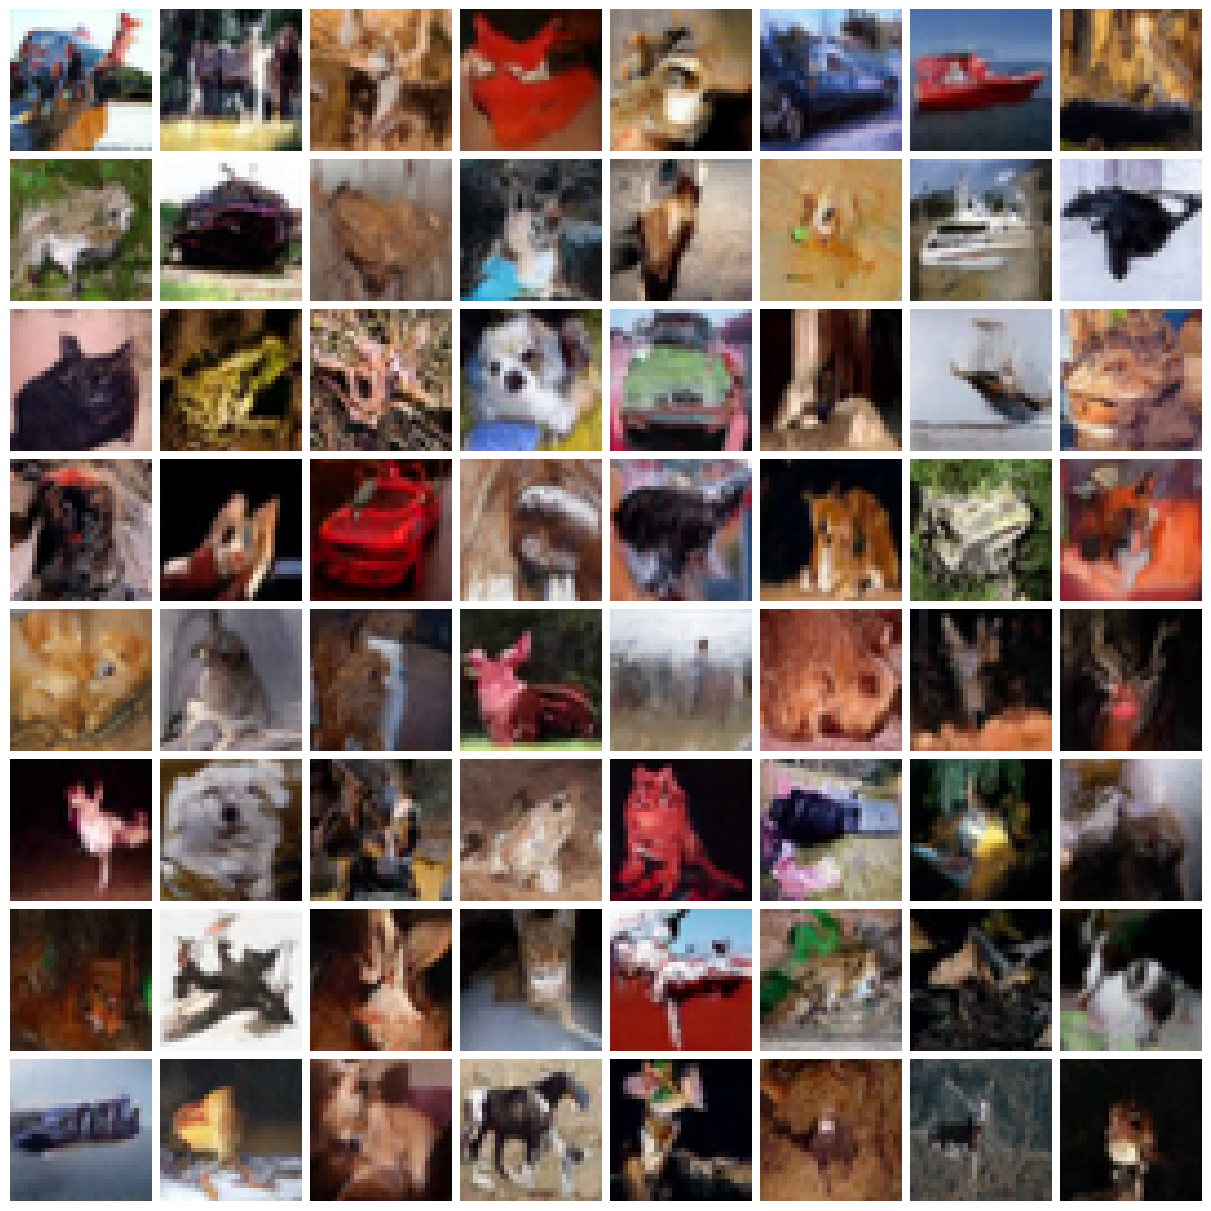

In [15]:
# generate new images
fig = plt.figure(figsize=(12, 12), constrained_layout=True)
gs = fig.add_gridspec(8, 8)

imgs = generated_images[-1].reshape(8, 8, 3, 32, 32)
for n_row in range(8):
    for n_col in range(8):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        img = np.array((imgs[n_row, n_col].transpose([1, 2, 0])+1.0) * 255 / 2, dtype=np.uint8)
        f_ax.imshow(img)
        f_ax.axis("off")

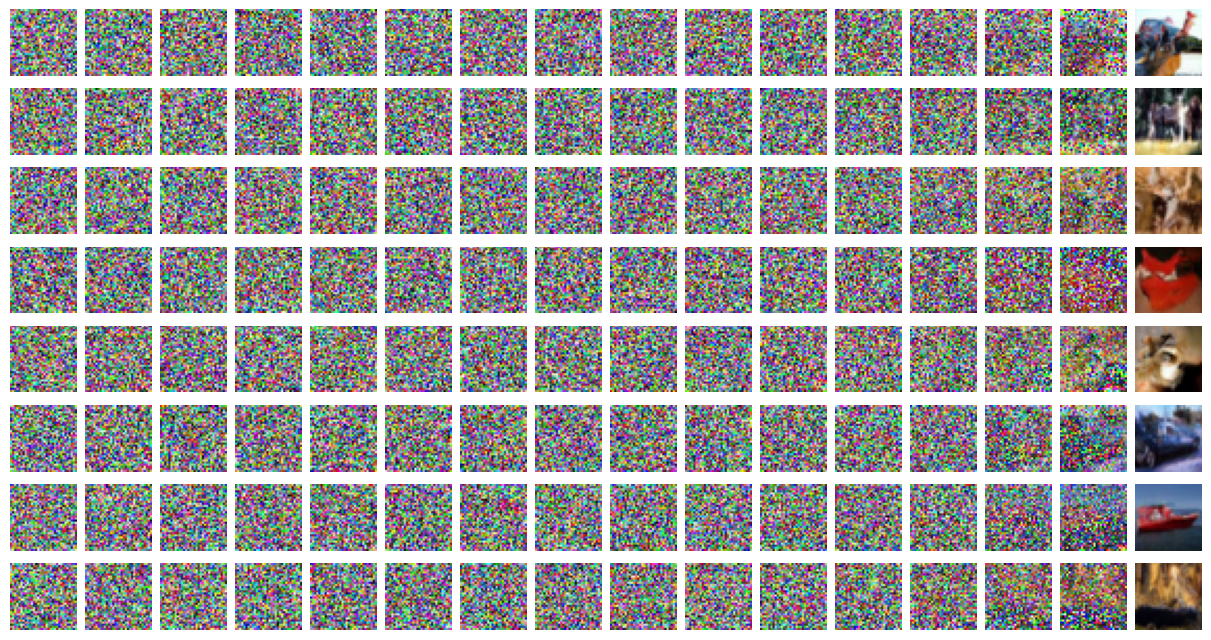

In [16]:
# show the denoise steps
fig = plt.figure(figsize=(12, 12), constrained_layout=True)
gs = fig.add_gridspec(16, 16)

for n_row in range(8):
    for n_col in range(16):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        t_idx = (timesteps // 16) * n_col if n_col < 15 else -1
        img = generated_images[t_idx][n_row].reshape(3, 32, 32).transpose([1, 2, 0])
        f_ax.imshow(np.array((img+1.0) * 255 / 2, dtype=np.uint8))
        f_ax.axis("off")